# 4 Training and Modeling Data<a id='4_Training_and_Modeling_Data'></a>

## Contents <a id ="Content" > </a>

* [Introduction](#Introduction)
* [Imports](#Imports)
* [Train Test Split](#Train_Test_Split) 
* [Training and Modeling](#Training_and_Modeling)
    * [Model Selection](#Model_Selection)
    * [Evaluation Metrics](#Evaluation-Metrics)
        * [Training and Modeling](#Train_and_Model)
        * [Hyperparameter Tuning and Model Training](#Hyperparameter_Tuning_Training)
            * [Logistic Regression](#Logistic_Regression)
            * [Evaluation](#Evaluation)
* [Additional Models](#AdditionalModels)
* [Summary](#Summary)
* [Recommendations](#Recom)

## Imports <a id="Imports"></a>

In [73]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import pipeline
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import neighbors
from xgboost import XGBClassifier

#from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
import matplotlib.pyplot as plt

# remove warning
#import warnings
#warnings.filterwarnings("ignore")


In [250]:
X_train = pd.read_csv("../data/4.X_train.csv")
y_train = pd.read_csv("../data/4.y_train.csv")
X_test = pd.read_csv("../data/4.X_test.csv")
y_test = pd.read_csv("../data/4.y_test.csv")

In [4]:
X_train.shape,y_train.shape

((7088, 16), (7088, 1))

In [5]:
X_test.shape,y_test.shape

((3039, 16), (3039, 1))

In [6]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,7088.0,-3.454018e-16,1.000071,-2.531322,-0.661337,-0.038008,0.709986,3.327966
Credit_Limit,7088.0,8.597793e+00,0.930669,7.271217,7.841395,8.418587,9.298671,10.449178
Total_Revolving_Bal,7088.0,9.103482e-01,0.638103,0.000000,0.248822,1.000000,1.396112,1.977219
Total_Trans_Amt,7088.0,8.167921e+00,0.656979,6.390241,7.674617,8.267449,8.468633,9.824661
Avg_Utilization_Ratio,7088.0,2.753070e-01,0.276635,0.000000,0.023000,0.175000,0.502000,0.999000
Gender_Encoded,7088.0,5.328725e-01,0.498953,0.000000,0.000000,1.000000,1.000000,1.000000
Dependent_count,7088.0,2.344949e+00,1.299597,0.000000,1.000000,2.000000,3.000000,5.000000
Education_Level_sorted,7088.0,2.839306e+00,1.215114,1.000000,2.000000,3.000000,3.000000,6.000000
Income_Category_sorted,7088.0,2.175226e+00,1.334986,1.000000,1.000000,2.000000,3.000000,5.000000
Card_Category_sorted,7088.0,1.081546e+00,0.330233,1.000000,1.000000,1.000000,1.000000,4.000000


In [7]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,3039.0,1.760867e-16,1.000165,-2.545475,-0.671517,-0.046864,0.702719,2.701607
Credit_Limit,3039.0,8.616519e+00,0.940983,7.271217,7.854381,8.432724,9.328701,10.449178
Total_Revolving_Bal,3039.0,9.134881e-01,0.640117,0.000000,0.349961,1.000000,1.401403,1.961808
Total_Trans_Amt,3039.0,8.157574e+00,0.648578,6.234411,7.682021,8.271293,8.453401,9.797849
Avg_Utilization_Ratio,3039.0,2.739293e-01,0.273522,0.000000,0.022500,0.177000,0.503500,0.994000
Gender_Encoded,3039.0,5.202369e-01,0.499673,0.000000,0.000000,1.000000,1.000000,1.000000
Dependent_count,3039.0,2.349128e+00,1.297511,0.000000,1.000000,2.000000,3.000000,5.000000
Education_Level_sorted,3039.0,2.851925e+00,1.201185,1.000000,2.000000,3.000000,3.000000,6.000000
Income_Category_sorted,3039.0,2.199079e+00,1.332057,1.000000,1.000000,2.000000,3.000000,5.000000
Card_Category_sorted,3039.0,1.088516e+00,0.341929,1.000000,1.000000,1.000000,1.000000,4.000000


## Training and Modeling <a id=Training_and_Modeling ></a>

### Fit Model on Intercept (naive model)

In [99]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().ravel()

In [100]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy().ravel()

In [10]:
def threshhold_and_plot(y_test,target,n_points=50,plot=True):
    probs = np.linspace(0,1,n_points)
    def make_thresh(): 
        precision = [metrics.precision_score(y_test,np.where(target > thresh,1,0),zero_division=1) for thresh in probs]
        recall = [metrics.recall_score(y_test,np.where(target > thresh,1,0),labels=np.unique(target),zero_division=1) for thresh in probs]
        f1 = [metrics.f1_score(y_test,np.where(target > thresh,1,0),labels=np.unique(target),zero_division=1) for thresh in probs]
        return precision,recall,f1

    precision,recall,f1 = make_thresh()
    if plot:
        plt.plot(probs,precision,label='precision')
        plt.plot(probs,recall,label='recall')
        plt.plot(probs,f1,label='f1')
        plt.title("Metrics at different threshold")
        plt.xlabel("Probability")
        plt.legend()
        return precision,recall,f1
    else:
        return precision,recall,f1
    
def max_thresh(score_vec):
    max_idx=np.argmax(score_vec)
    max_score=score_vec[max_idx]
    return max_idx,max_score

In [174]:
#plot roc
def plot_roc(actuals,preds):
    fpr, tpr, thresholds = metrics.roc_curve(actuals, preds)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.show()
    return 

In [12]:
def make_confusion_matrix(y_actual,y_predict,title):
    fig, ax = plt.subplots(1, 1)
    
    Con_Mtx = metrics.confusion_matrix(y_actual, y_predict, labels=[0,1])
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=Con_Mtx,
                               display_labels=["No","Yes"])
    disp.plot(cmap='Blues',ax=ax)
    
    ax.set_title(title)
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None,axis='both',which='both',visible=False)
    plt.show()

In [13]:
null_reg = linear_model.LogisticRegression(fit_intercept= False,max_iter=500,random_state=632966)

In [14]:
X_train_null = np.ones(shape=y_train.shape[0]).reshape(-1,1)
X_test_null = np.ones(shape=y_test.shape[0]).reshape(-1,1)

In [15]:
#fit on train and test data no tuning
null_train = null_reg.fit(X=X_train_null,y=y_train)
null_test = null_reg.fit(X=X_test_null,y=y_test)

In [16]:
#predict_proba and pred_prob returns two columns, second one is target
train_pred = null_train.predict_proba(X_train_null)
test_pred = null_train.predict_proba(X_test_null)

In [17]:
#base metrics: minmum performance
metrics.precision_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0),zero_division=1)

1.0

In [18]:
metrics.recall_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0))

0.0

In [19]:
metrics.f1_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0),zero_division=1)

0.0

In [20]:
#check to see if close to population value
print("Observed: {:.3f}, Fit: {:.3f}".format(y_train.mean(),train_pred[:,1].mean()))

Observed: 0.161, Fit: 0.161


In [21]:
model_params = {"model__C": (np.logspace(start=-4,stop=4,num=30))}
#pipe line has just model object
model_pipeline = pipeline.Pipeline(steps=[("model",null_reg)])
# set up cross-validator:
# 80/20 train/calibration split in this data (test data still held out)
# 200 iterations
# feel free to use another CV method and explain why
cross_validator = (
  model_selection.StratifiedShuffleSplit(train_size=0.8,
                                          random_state=1337,
                                          n_splits=50))
# set up grid search
model_grid = (
  model_selection.GridSearchCV(estimator=model_pipeline,
                           param_grid=model_params,
                           refit=True, # refit using best estimates
                           scoring="roc_auc", # metric to optimize (can pick another)
                           cv=cross_validator,
                           n_jobs = -1))

In [22]:
%%time
# fit model on intercept (random guesses - baseline performance)
null_mod = model_grid.fit(X_train_null,y_train)

Wall time: 3.6 s


In [23]:
%%time
cv_scores = (
  model_selection.cross_val_score(null_mod,
                                  X_train_null,
                                  y_train,
                                  scoring="roc_auc",
                                  cv=cross_validator,
                                  n_jobs=-1))

Wall time: 1min 51s


In [222]:
print("Observed: {:.3f}".format(y_train.mean()))

Observed: 0.161


In [26]:
cv_quantiles = np.quantile(a=cv_scores,q=[0.025,0.975])
print(f" 2.5%:{cv_quantiles[0]:.3f},97.5%:{cv_quantiles[1]:.3f}")

 2.5%:0.500,97.5%:0.500


<AxesSubplot:ylabel='Count'>

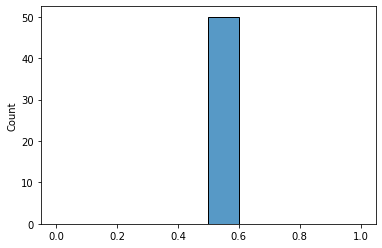

In [27]:
import seaborn as sns
sns.histplot(cv_scores, bins=10)

In [28]:
max_thresh(cv_scores)

(0, 0.5)

In [29]:
#on test data
p_test,r_test,f1_test = threshhold_and_plot(y_test,test_pred[:,1],plot=False)
# now on train data
p_train,r_train,f1_train =  threshhold_and_plot(y_test=y_train, target=train_pred[:,1],n_points=50, plot=False)

In [30]:
max_precison_test_idx, max_precison_test_val = max_thresh(p_test)
max_precison_train_idx, max_precison_train_val = max_thresh(p_train)
print("Max Test precision - {} at index {}".format(max_precison_test_val,max_precison_test_idx))
print("Max Train precision - {} at index {}".format(max_precison_train_val,max_precison_train_idx))

Max Test precision - 1.0 at index 8
Max Train precision - 1.0 at index 8


In [31]:
auc_score = metrics.roc_auc_score(y_test, test_pred[:,1])
print(f"Scikit's ROC-AUC score of SVC model is {auc_score: .4f}")

Scikit's ROC-AUC score of SVC model is  0.5000


In [32]:
# check to see if close to population value
print(f"Observed: {y_train.mean():.3f} Fit: {train_pred[:,1].mean():.3f}")

Observed: 0.161 Fit: 0.161


## Logistics Regression

Thinking of customer will not exit but he does, this means income loss for the Bank. Bank need to take the action steps for this scenario. This is false positive, and is "precision". Banks  is looking for precision to be maximized, greater the precision lesser the chances of false positives means lesser chances of predicting customers will not  exit where in reality they do.

In [33]:
clf_lg = linear_model.LogisticRegression(fit_intercept= True,max_iter=500,random_state=632966)

model_params_lg = {"model__C": (np.logspace(start=-4,stop=4,num=30))} 

model_pipeline_lg = pipeline.Pipeline(steps=[("model",clf_lg)])

cross_validator = (
    model_selection.StratifiedShuffleSplit(train_size=0.8,
                                           random_state=1337,
                                           n_splits=50))

# set up grid search
model_grid_lg = (
  model_selection.GridSearchCV(estimator=model_pipeline_lg,
                               param_grid=model_params_lg,
                               refit=True, # refit using best estimates
                               scoring="roc_auc", 
                               cv=cross_validator,
                               n_jobs = -1))

In [34]:
%%time
lg_mod = model_grid_lg.fit(X_train,y_train)

Wall time: 26.1 s


In [35]:
# Setting to the best combination of parameters
lr_reg = lg_mod.best_estimator_
# Fit the best algorithm to the data. 
lr_reg.fit(X_train, y_train)

Pipeline(steps=[('model',
                 LogisticRegression(C=0.20433597178569418, max_iter=500,
                                    random_state=632966))])

In [36]:
%%time
cv_scores_lg = (
  model_selection.cross_val_score(lr_reg,
                                  X_train,
                                  y_train,
                                  scoring="roc_auc",
                                  cv=cross_validator,
                                  n_jobs=-1))

Wall time: 1.06 s


In [37]:
cv_quantiles = np.quantile(a=cv_scores_lg,q=[0.025,0.975])
print(f" 2.5%:{cv_quantiles[0]:.3f},97.5%:{cv_quantiles[1]:.3f}")

 2.5%:0.799,97.5%:0.854


<AxesSubplot:ylabel='Count'>

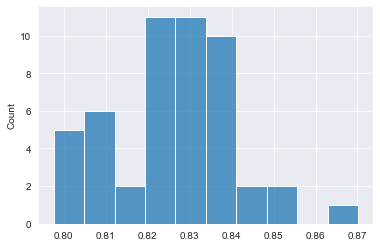

In [38]:
sns.set_style("darkgrid")
sns.histplot(cv_scores_lg, bins=10)

In [39]:
max_thresh(cv_scores_lg)

(8, 0.8701312103788884)

In [40]:
true_train_preds = lr_reg.predict(X_train)
true_test_preds = lr_reg.predict(X_test)

In [41]:
#find precision threshold on test data
p_test_lg,_,_ =  threshhold_and_plot(y_test=y_test, target=true_test_preds,n_points=50, plot=False)
#find  precision threshold on train data
p_train_lg, _,_=  threshhold_and_plot(y_test=y_train, target=true_train_preds,n_points=50, plot=False)

In [42]:
max_precison_lgtest_idx, max_precison_lgtest_val = max_thresh(p_test_lg)
max_precison_lgtrain_idx, max_precison_lgtrain_val = max_thresh(p_train_lg)
print("Max Test precision - {} at index {}".format(max_precison_lgtest_val,max_precison_lgtest_idx))
print("Max Train precision - {} at index {}".format(max_precison_lgtrain_val,max_precison_lgtrain_idx))

Max Test precision - 1.0 at index 49
Max Train precision - 1.0 at index 49


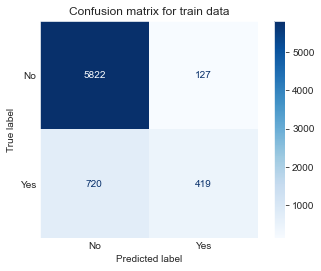

accuracy_score : 0.8805022573363431

True +ve : 419
True -ve : 5822
False +ve : 127
False -ve : 720



In [43]:
#Confusion matrix for train data
title = "Confusion matrix for train data"
make_confusion_matrix(y_train, true_train_preds,title)
print("accuracy_score : {0}\n".format(metrics.accuracy_score(y_train, true_train_preds)))
tn, fp, fn, tp = metrics.confusion_matrix(y_train, true_train_preds).ravel()
print("True +ve : {0}\nTrue -ve : {1}\nFalse +ve : {2}\nFalse -ve : {3}\n".format(tp,tn,fp,fn))

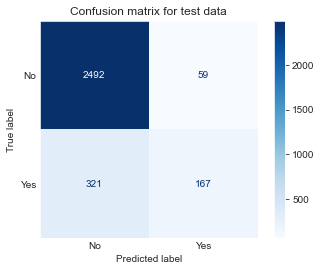

accuracy_score : 0.8749588680487003

True +ve : 167
True -ve : 2492
False +ve : 59
False -ve : 321



In [44]:
#Confusion matrix for test data
title = "Confusion matrix for test data"
make_confusion_matrix(y_test, true_test_preds,title)
print("accuracy_score : {0}\n".format(metrics.accuracy_score(y_test, true_test_preds)))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, true_test_preds).ravel()
print("True +ve : {0}\nTrue -ve : {1}\nFalse +ve : {2}\nFalse -ve : {3}\n".format(tp,tn,fp,fn))

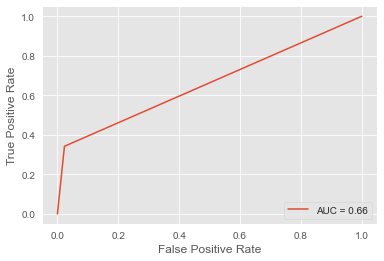

[2 1 0]


In [175]:
thresh = plot_roc(y_test, true_test_preds)
print(thresh)

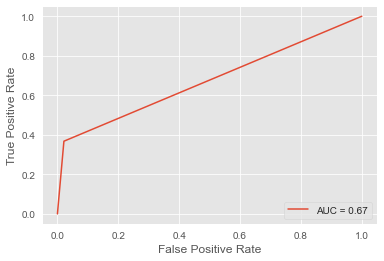

In [171]:
#plot roc
plot_roc(y_train, true_train_preds)

In [47]:
#classifier
clf_lg = linear_model.LogisticRegression(fit_intercept= True,max_iter=500,random_state=632966)

# Grid of parameters
model_params_lg = {"model__C": (np.logspace(start=-4,stop=4,num=30)),
                   'model__penalty': ['l2']} 
#'model__solver' : ['liblinear','newton-cg','lbfgs','sag','saga'],

# pipeline
model_pipeline_lg = pipeline.Pipeline(steps=[("model",clf_lg)])

cross_validator = (model_selection.StratifiedShuffleSplit(train_size=0.8,random_state=1337,n_splits=50))

# set up grid search
model_grid_lg = (
  model_selection.GridSearchCV(estimator=model_pipeline_lg,
                               param_grid=model_params_lg,
                               refit=True, # refit using best estimates
                               scoring="roc_auc", cv=cross_validator,n_jobs = -1,verbose=1))

In [48]:
%%time
# Fit the best algorithm to the data. 
model_grid_lg.fit(X_train, y_train)

Fitting 50 folds for each of 30 candidates, totalling 1500 fits
Wall time: 27.8 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=1337, test_size=None,
            train_size=0.8),
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(max_iter=500,
                                                           random_state=632966))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'model__penalty': ['l2']},
             scoring='roc_a

In [49]:
model_grid_lg.best_params_,model_grid_lg.best_score_

({'model__C': 0.20433597178569418, 'model__penalty': 'l2'}, 0.8257422969187675)

In [50]:
# Setting to the best combination of parameters
lr_reg = model_grid_lg.best_estimator_
# Fit the best algorithm to the data. 
lr_reg.fit(X_train, y_train)

Pipeline(steps=[('model',
                 LogisticRegression(C=0.20433597178569418, max_iter=500,
                                    random_state=632966))])

In [51]:
true_train_preds = lr_reg.predict(X_train)
true_test_preds = lr_reg.predict(X_test)

In [52]:
%%time
cv_scores_lg = (
  model_selection.cross_val_score(lr_reg,
                                  X_train,
                                  y_train,
                                  scoring="recall",
                                  cv=cross_validator,
                                  n_jobs=-1))

Wall time: 1.19 s


In [53]:
cv_quantiles = np.quantile(a=cv_scores_lg,q=[0.025,0.975])
print(f" 2.5%:{cv_quantiles[0]:.3f},97.5%:{cv_quantiles[1]:.3f}")

 2.5%:0.303,97.5%:0.420


<AxesSubplot:ylabel='Count'>

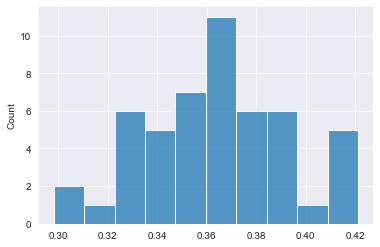

In [54]:
sns.set_style("darkgrid")
sns.histplot(cv_scores_lg, bins=10)

In [55]:
max_thresh(cv_scores_lg)

(3, 0.42105263157894735)

In [56]:
test_precision_lg,_, _ =  threshhold_and_plot(y_test=y_test, target=true_test_preds,n_points=50, plot=False)
train_precision_lg, _, _ =  threshhold_and_plot(y_test=y_train, target=true_train_preds,n_points=50, plot=False)
max_precison_lgtest_idx, max_precison_lgtest_val = max_thresh(test_precision_lg)
max_precison_lgtrain_idx, max_precison_lgtrain_val = max_thresh(train_precision_lg)
print("Max Test precision - {} at index {}".format(max_precison_lgtest_val,max_precison_lgtest_idx))
print("Max Train precision - {} at index {}".format(max_precison_lgtrain_val,max_precison_lgtrain_idx))

Max Test precision - 1.0 at index 49
Max Train precision - 1.0 at index 49


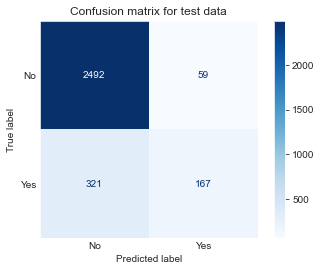

accuracy_score : 0.8749588680487003

True +ve : 167
True -ve : 2492
False +ve : 59
False -ve : 321



In [57]:
#Confusion matrix for test data
title = "Confusion matrix for test data"
make_confusion_matrix(y_test, true_test_preds,title)
print("accuracy_score : {0}\n".format(metrics.accuracy_score(y_test, true_test_preds)))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, true_test_preds).ravel()
print("True +ve : {0}\nTrue -ve : {1}\nFalse +ve : {2}\nFalse -ve : {3}\n".format(tp,tn,fp,fn))

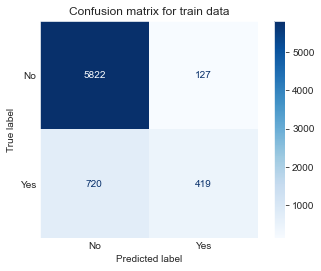

accuracy_score : 0.8805022573363431

True +ve : 419
True -ve : 5822
False +ve : 127
False -ve : 720



In [58]:
title = "Confusion matrix for train data"
make_confusion_matrix(y_train, true_train_preds,title)
print("accuracy_score : {0}\n".format(metrics.accuracy_score(y_train, true_train_preds)))
tn, fp, fn, tp = metrics.confusion_matrix(y_train, true_train_preds).ravel()

print("True +ve : {0}\nTrue -ve : {1}\nFalse +ve : {2}\nFalse -ve : {3}\n".format(tp,tn,fp,fn))

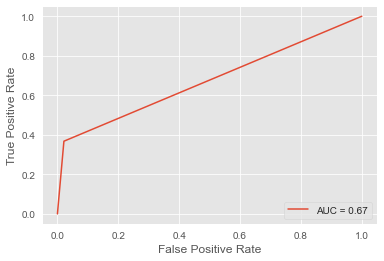

In [172]:
plot_roc(y_train, true_train_preds)

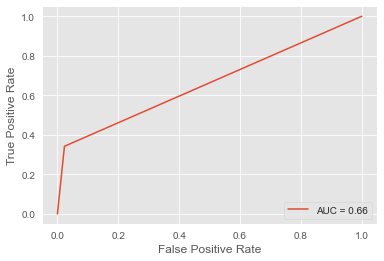

In [173]:
plot_roc(y_test, true_test_preds)

### Model Selection 

Four competing supervised classfication models/algorithms are considered, namely, 
* Logistic Regression classification
* Random Forest classifier
* KNeighbours classification
* XGBoost classifier 

### Evaluation Metrics

Since classes in the data are unbalanced, I can make use of confusion matrix to examine the outcome of model. Recall and precision metrics can be calculated from the confusion matrix, and this would help me assessing the models.

This project is aim to predict potential churn customers, and it is realised that the client cost of mistakenly classifying non-churn customer as churn may be high in practice because banks would not want to lose valuable customers, and the banks would like to identify churners at their best efforts as well. Thus, it would be useful to consider Precision. To complement this Receiver Operating Characteristic curve (ROC) is used. ROC is a plot of True Positive Rate (TPR) against False Positive Rate (FPR). This means I can consider TPR and FPR simultanesouly, by making use of the area under the curve (AUC) of ROC.

### Training and Modeling

In [74]:
# models listing and fitting
models = [
        linear_model.LogisticRegression(),
        ensemble.RandomForestClassifier(),
        neighbors.KNeighborsClassifier(),
        XGBClassifier(use_label_encoder=False)
        ]

for model in models :
            model.fit(X_train,y_train)

[01:35:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


classifier name: Logistic Regression


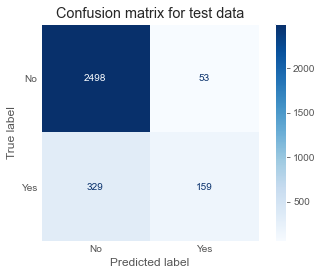

accuracy_score : 0.8743007568279039

True +ve : 159
True -ve : 2498
False +ve : 53
False -ve : 329



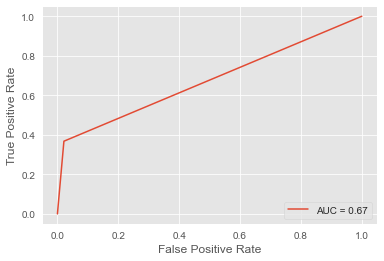

classifier name: RandomForest Classifier


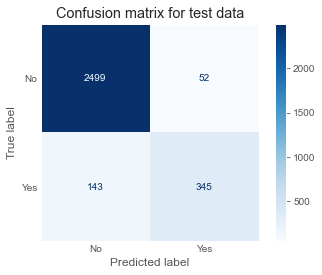

accuracy_score : 0.9358341559723593

True +ve : 345
True -ve : 2499
False +ve : 52
False -ve : 143



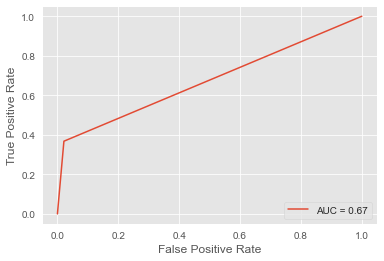

classifier name: KNeighbors Classifier


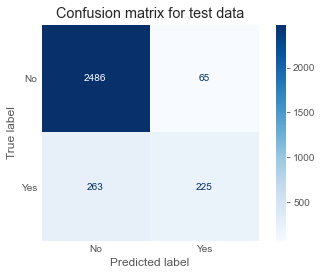

accuracy_score : 0.8920697597894044

True +ve : 225
True -ve : 2486
False +ve : 65
False -ve : 263



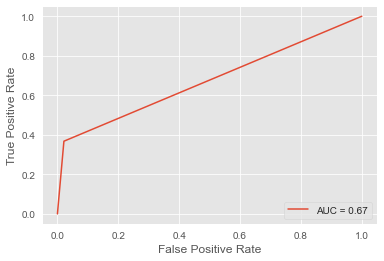

classifier name: XGBClassifier


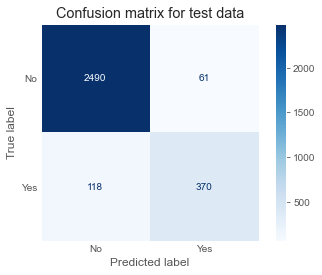

accuracy_score : 0.9410990457387298

True +ve : 370
True -ve : 2490
False +ve : 61
False -ve : 118



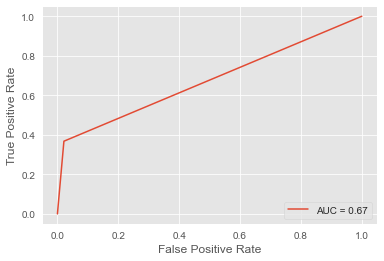

In [256]:
#Model predition
model_names = [
        'Logistic Regression',
        'RandomForest Classifier',
        'KNeighbors Classifier',
        'XGBClassifier'
]

for classifier,classifier_name in zip(models,model_names):
    prediction=classifier.predict(X_test)
    print('classifier name: ' + classifier_name)
    
    title = "Confusion matrix for test data"
    make_confusion_matrix(y_test,prediction,title)
    print("accuracy_score : {0}\n".format(metrics.accuracy_score(y_test,prediction)))
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,prediction).ravel()
    print("True +ve : {0}\nTrue -ve : {1}\nFalse +ve : {2}\nFalse -ve : {3}\n".format(tp,tn,fp,fn))
    plot_roc(y_train, true_train_preds)

Best Model is from XG Classifier with Score 94%

### Feature Importance

Finding Feature importance and selecting top 8 features

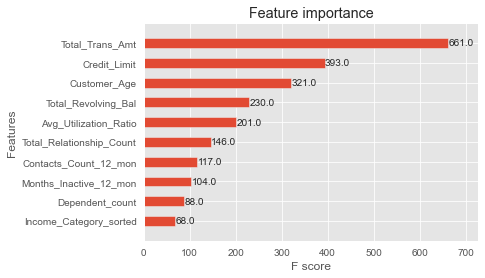

<Figure size 1440x1440 with 0 Axes>

['Total_Revolving_Bal', 0.18961056]
['Total_Trans_Amt', 0.14141884]
['Total_Relationship_Count', 0.1392616]
['Months_Inactive_12_mon', 0.08161943]
['Gender_Encoded', 0.07091206]
['Customer_Age', 0.063494116]
['Contacts_Count_12_mon', 0.050714638]
['Credit_Limit', 0.045570944]
['Marital_Status_sorted_Married', 0.045564655]
['Dependent_count', 0.03548129]
['Avg_Utilization_Ratio', 0.034051042]
['Marital_Status_sorted_Single', 0.02745477]
['Education_Level_sorted', 0.025964404]
['Income_Category_sorted', 0.024694106]
['Card_Category_sorted', 0.024187576]
['Months_on_book', 0.0]


In [236]:
from xgboost import XGBRegressor,plot_importance
import matplotlib.pyplot as plt
#xgb = XGBRegressor(n_estimators=100)
xgb = XGBClassifier(booster="gbtree", verbosity=0, use_label_encoder=False,n_jobs=-1)
xgb.fit(X_train, y_train)
   
plot_importance(xgb, max_num_features = 10,height=0.5)
plt.figure(figsize=(20,20))
plt.show()

sorted_idx = np.argsort(xgb.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_train.columns[index], xgb.feature_importances_[index]])

From the F1 score graph the top 8 features influence prediction are as below. 

* Total_Trans_Amt: Total Transaction Amount in Last 12 months((one year))
* Credit_Limit: Credit Limit on the Credit Card
* Customer_Age: Age in Years
* Total_Revolving_Bal: The balance that carries over from one month to the next is the revolving balance
* Avg_Utilization_Ratio: Represents how much of the available credit the customer spent
* Total_Relationship_Count: Total no. of products held by the customer
* Contacts_Count_12_mon: No. of Contacts between the customer and bank in the last 12 months(one year)
* Months_Inactive_12_mon: No. of months inactive in the last 12 months(one year)

I will use these above features on my selected models, to gain the predictive analysis
* Logistic Regression classification
* Random Forest classifier
* KNeighbours classification
* XGBoost classifie

In [253]:
cols = ['Customer_Age', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Trans_Amt', 'Avg_Utilization_Ratio', 'Total_Relationship_Count',
        'Contacts_Count_12_mon','Months_Inactive_12_mon']
        
X_train = pd.DataFrame(X_train,columns=cols)
X_test = pd.DataFrame(X_test,columns=cols)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().ravel()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy().ravel()

In [254]:
# models listing and fitting
models = [
        linear_model.LogisticRegression(),
        ensemble.RandomForestClassifier(),
        neighbors.KNeighborsClassifier(),
        XGBClassifier(use_label_encoder=False)
        ]

for model in models :
            model.fit(X_train,y_train)

classifier name: Logistic Regression


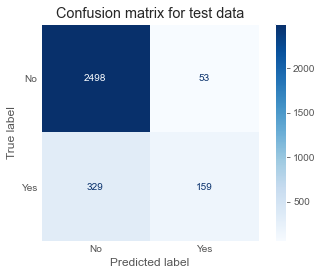

accuracy_score : 0.8743007568279039

True +ve : 159
True -ve : 2498
False +ve : 53
False -ve : 329



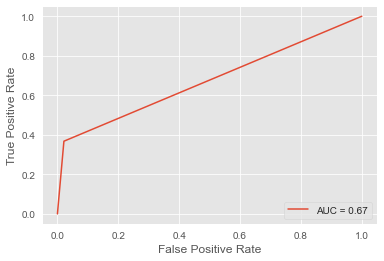

classifier name: RandomForest Classifier


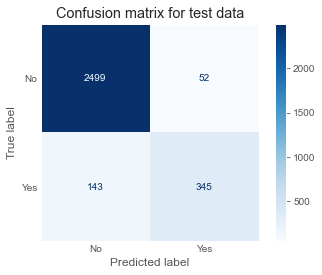

accuracy_score : 0.9358341559723593

True +ve : 345
True -ve : 2499
False +ve : 52
False -ve : 143



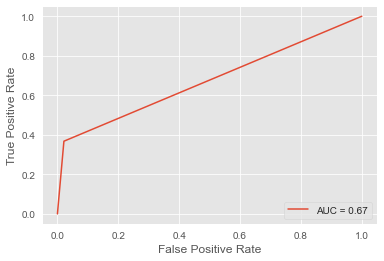

classifier name: KNeighbors Classifier


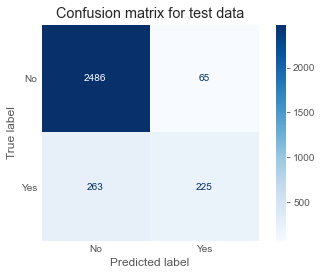

accuracy_score : 0.8920697597894044

True +ve : 225
True -ve : 2486
False +ve : 65
False -ve : 263



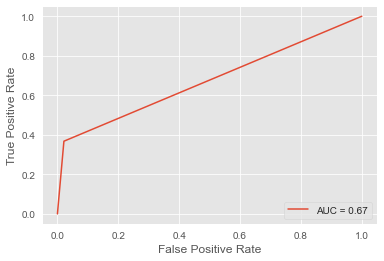

classifier name: XGBClassifier


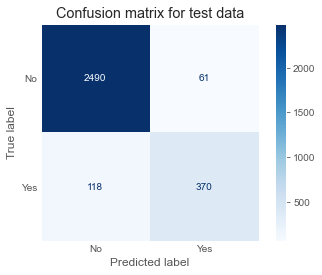

accuracy_score : 0.9410990457387298

True +ve : 370
True -ve : 2490
False +ve : 61
False -ve : 118



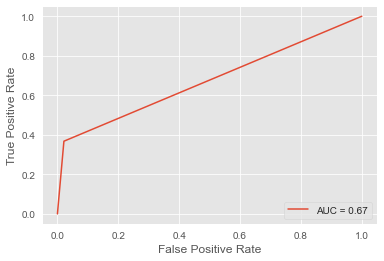

In [257]:
#Model predition
model_names = [
        'Logistic Regression',
        'RandomForest Classifier',
        'KNeighbors Classifier',
        'XGBClassifier'
]

for classifier,classifier_name in zip(models,model_names):
    prediction=classifier.predict(X_test)
    print('classifier name: ' + classifier_name)
    
    title = "Confusion matrix for test data"
    make_confusion_matrix(y_test,prediction,title)
    print("accuracy_score : {0}\n".format(metrics.accuracy_score(y_test,prediction)))
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,prediction).ravel()
    print("True +ve : {0}\nTrue -ve : {1}\nFalse +ve : {2}\nFalse -ve : {3}\n".format(tp,tn,fp,fn))
    plot_roc(y_train, true_train_preds)

### Hyperparameter Tuning and Model Training

Each model is subject to various hyperparameters that need to be determined. Here random search and grid search methods are used optimise the hyperparameters for our chosen models. Grid search exhaustively checks every combinations of hyperparameters given in the parameter domain to optimise the given score, "roc_auc" in this project. Random search checks random combinations of hyperparameters for a given number of iterations to optimise the given score. The advantage of random search is shorter time but the trade-off is that it might miss the best possible combination.

Below are the two functions, rand_search(), and grid_search(), to help in implementation. No scaling is done as it is each feature is already scaled, so then train the models with training dataset.


In [279]:
# rand search function
def rand_search(X_train,y_train,parameters,model,n_iter=100):
    scoring = 'roc_auc'
    verbose = 1
    clf_pipeline = Pipeline([("clf",model)])   
    clf_rand = model_selection.RandomizedSearchCV(clf_pipeline, parameters, n_iter = n_iter,scoring=scoring,verbose = verbose, random_state=1,n_jobs=-1)
    clf_rand.fit(X_train,y_train)  #learn the training set
    
    print("Best parameters for ", model) 
    print(clf_rand.best_params_)
    print(f"\nBest train %s score: {clf_rand.best_score_ :.2f}" % (scoring))
    return clf_rand.best_estimator_

In [267]:
# grid search function
def grid_search(X_train,y_train,parameters,model):
    scoring = 'roc_auc'
    verbose = 1
    clf_pipeline = Pipeline([("clf",model)])   #Pipeline applies scaling and model estimator
    clf_grid = model_selection.GridSearchCV(clf_pipeline, parameters,  scoring=scoring,verbose = verbose)
    clf_grid.fit(X_train,y_train) 

    print("Best parameters for ", model) 
    print(clf_grid.best_params_)
    print(f"\nBest train %s score: {clf_grid.best_score_ :.2f}" % (scoring))
    return clf_grid.best_estimator_

### Logistic Regression

This is the basic regression classification

In this package, there are several hyperparameters that we need to pay attention to:

      C: controls the strength of regularisation penalty
      solver: algorithms used for optimisation
      class_weight: weights associated with classes

In [264]:
#Setting ranges for each hyperparameter.
log_params = {"clf__solver": ["lbfgs", "sag", "saga"],
               "clf__C": np.arange(0.1,2,0.1), 
               "clf__class_weight": ["balanced", None]
              }

In [269]:
classifier = linear_model.LogisticRegression(fit_intercept= True,max_iter=500,random_state=632966)
log_best_estimator = grid_search(X_train,y_train, log_params,classifier)

Fitting 5 folds for each of 114 candidates, totalling 570 fits
Best parameters for  LogisticRegression(max_iter=500, random_state=632966)
{'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__solver': 'saga'}

Best train roc_auc score: 0.82


### Random Forest Classification

Random Forest consists of an ensemble of decision trees. The algorithm splits the dataset into independent random subsamples and selects subsamples of features, and fits a decision tree classfier to each subsample. It then averages the estimates to improve the prediction accuracy.

We will use the class sklearn.ensemble.RandomForestClassifier from scikit learn. Based on our research, there are several hyperparameters that we will need to adjust:

      n_estimator: the number of trees in the forest
      min_samples_split:the minimum number of data points required to be at a leaf node
      max_features: the number of features to consider when looking for the best split
      max_depth: the maximum depth of the tree

In [281]:
#Setting ranges for each parameter.
clf__max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
rfc_params = {"clf__n_estimators": np.linspace(start = 100, stop = 1000, num = 10,dtype=int),
              "clf__min_samples_split": np.arange(2,6), 
              "clf__max_features":["sqrt", "log2"],
              "clf__max_depth": clf__max_depth
             }

In [282]:
classifier=RandomForestClassifier(random_state=1,n_jobs=-1)
#classifier__max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
#classifier__max_depth.append(None)

rfc_best_estimator = rand_search(X_train,y_train, rfc_params, classifier,n_iter=120) #apply random search

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  RandomForestClassifier(n_jobs=-1, random_state=1)
{'clf__n_estimators': 600, 'clf__min_samples_split': 3, 'clf__max_features': 'log2', 'clf__max_depth': 10}

Best train roc_auc score: 0.96


### KNeighbours Classification

KNeighbours classfication chooses K nearest data points to the unlabeled data point then ask the K neighbours to "vote" for the classes that the point belongs to.

We will use the class sklearn.neighbors.KNeighborsClassifier for the implementation. Important hyperparameters that we will adjust are shown as follows:

      n_neighbors: the number of closest neigbours
      weights: weight function in prediction
      p: Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2




In [283]:
#Setting ranges for the hyperparameters are shown below.
knn_params = {"clf__n_neighbors":[2,5,10,87,100],
              "clf__weights":["uniform", "distance"],
              "clf__p":[1,2] 
             }

In [284]:
classifier = neighbors.KNeighborsClassifier(n_jobs=-1)
knn_best_estimator = grid_search(X_train,y_train, knn_params, classifier)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for  KNeighborsClassifier(n_jobs=-1)
{'clf__n_neighbors': 87, 'clf__p': 1, 'clf__weights': 'distance'}

Best train roc_auc score: 0.91


### XGBoost Classification

XGBoost uses gradient boosting technique, and is on the priciples of decison tree ensemble, which a set of classification and regression trees. It is similar to Random Forest difference is how the algorithms train the models.

The hyperparameters we need to fine-tune are as follows:

      learning_rate: the learning rate of gradient boosting
      max_depth:maximum tree depth
      min_child_weight: minimum sum of instance weight(hessian) needed in a child. Useful to reduce overfitting
      reg_lambda: L2 regularisation


In [285]:
#Settingranges for the hyperparameter are shown below.
xgb_params = {"clf__learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
               "clf__max_depth": np.arange(2,7),
               "clf__min_child_weight": np.arange(1,11),
               "clf__reg_lambda": np.linspace(0.1,1,num=10)
              }

In [286]:
classifier = XGBClassifier(booster="gbtree", verbosity=0, use_label_encoder=False,n_jobs=-1)

xgb_best_estimator = rand_search(X_train,y_train, xgb_params,classifier,n_iter=120)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
{'clf__reg_lambda': 0.4, 'clf__min_child_weight': 2, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}

Best train roc_auc score: 0.97


### Evaluation 

Now run the model using the best estimators on the test set, and print out the confusion matrix and evaluation metrics.

In [287]:
# Evaluation outputs
evaluation = pd.DataFrame({'Model': [],
                           'Accuracy':[],
                          'Recall':[],
                          'Precision':[],
                          'F1':[],
                          'ROC_AUC':[]})

In [350]:
def evaluate_model(estimator, X_test, y_test, name):
    y_pred = estimator.predict(X_test)
    y_confusion = metrics.confusion_matrix(y_test, y_pred)
    y_class_report = metrics.classification_report(y_test, y_pred, target_names=["not 1", "1"])
    accuracy = metrics.accuracy_score(y_test, y_pred)*100
    recall = metrics.recall_score(y_test, y_pred)*100
    precision = metrics.precision_score(y_test, y_pred)*100
    f1 = metrics.f1_score(y_test, y_pred)*100
    
    if name != 'LogReg':
        y_proba = estimator.predict_proba(X_test)
        fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba[:,1])
    else:
        y_proba = estimator.decision_function(X_test)
        fpr, tpr,threshold = metrics.roc_curve(y_test, y_proba)

    y_auc = metrics.auc(fpr, tpr)*100
                                                                                                                                                                                                                                             
    r = evaluation.shape[0]
    evaluation.loc[r] = [name, accuracy, recall, precision, f1, y_auc]  

    print(name, "ROC_AUC Score: %.2f" % y_auc)
    print(name, "confusion matrix\n", y_confusion )
    print(name, "classification report\n", y_class_report )
    make_confusion_matrix(y_test, y_pred,name)

### Logistic Regression

Logistic Regression ROC_AUC Score: 81.28
Logistic Regression confusion matrix
 [[1962  589]
 [ 129  359]]
Logistic Regression classification report
               precision    recall  f1-score   support

       not 1       0.94      0.77      0.85      2551
           1       0.38      0.74      0.50       488

    accuracy                           0.76      3039
   macro avg       0.66      0.75      0.67      3039
weighted avg       0.85      0.76      0.79      3039



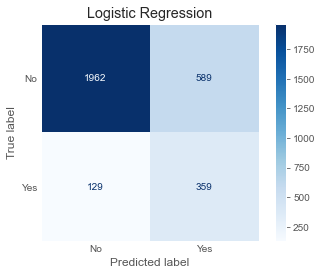

In [355]:
evaluate_model(log_best_estimator,X_test.values,y_test, 'Logistic Regression')

### Feature Importance

In [344]:
cols = ['Customer_Age', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Trans_Amt', 'Avg_Utilization_Ratio', 'Total_Relationship_Count',
        'Contacts_Count_12_mon','Months_Inactive_12_mon']
        
X_train = pd.DataFrame(X_train,columns=cols)
X_test = pd.DataFrame(X_test,columns=cols)

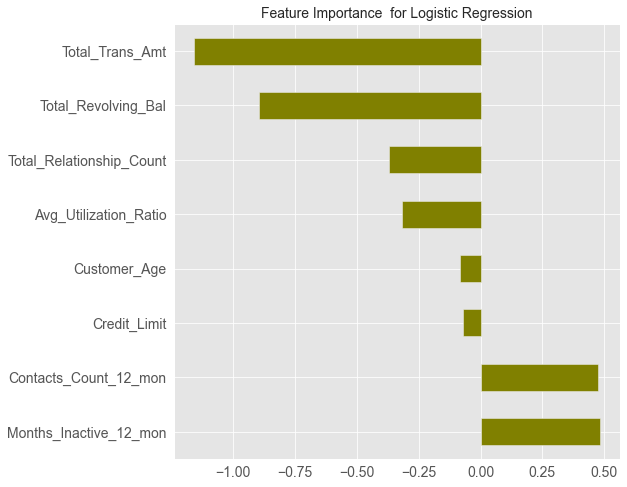

In [345]:
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.title('Feature Importance  for Logistic Regression', fontsize=14)
feat_importances = pd.Series(log_best_estimator.named_steps["clf"].coef_.tolist()[0], index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh',fontsize=14,color="olive")
plt.show()

### Random Forest Classification 

RandomForest Classifier ROC_AUC Score: 96.07
RandomForest Classifier confusion matrix
 [[2503   48]
 [ 144  344]]
RandomForest Classifier classification report
               precision    recall  f1-score   support

       not 1       0.95      0.98      0.96      2551
           1       0.88      0.70      0.78       488

    accuracy                           0.94      3039
   macro avg       0.91      0.84      0.87      3039
weighted avg       0.93      0.94      0.93      3039



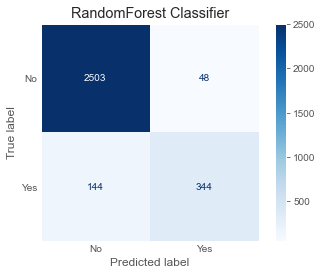

In [352]:
evaluate_model(rfc_best_estimator,X_test.values,y_test, 'RandomForest Classifier')

### Feature Importance

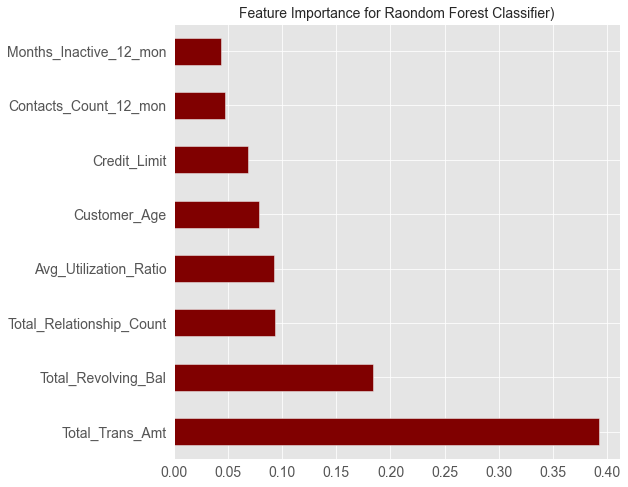

In [347]:
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.title('Feature Importance for Raondom Forest Classifier)', fontsize=14)
feat_importances = pd.Series(rfc_best_estimator.named_steps["clf"].feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh',fontsize = 14,color ='maroon')
plt.show()

### KNeighbours Classification 

KNeigbours Classifier ROC_AUC Score: 90.76
KNeigbours Classifier confusion matrix
 [[2539   12]
 [ 338  150]]
KNeigbours Classifier classification report
               precision    recall  f1-score   support

       not 1       0.88      1.00      0.94      2551
           1       0.93      0.31      0.46       488

    accuracy                           0.88      3039
   macro avg       0.90      0.65      0.70      3039
weighted avg       0.89      0.88      0.86      3039



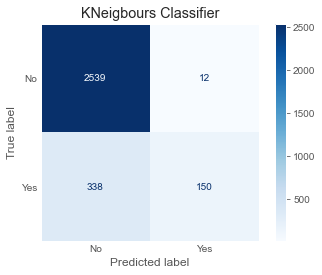

In [353]:
evaluate_model(knn_best_estimator,X_test.values,y_test, 'KNeigbours Classifier')

### Feature Importance

KNN does not have "feature_importances_" object

### XGBoost Classification

XGBoost Classifier ROC_AUC Score: 96.85
XGBoost Classifier confusion matrix
 [[2497   54]
 [ 114  374]]
XGBoost Classifier classification report
               precision    recall  f1-score   support

       not 1       0.96      0.98      0.97      2551
           1       0.87      0.77      0.82       488

    accuracy                           0.94      3039
   macro avg       0.92      0.87      0.89      3039
weighted avg       0.94      0.94      0.94      3039



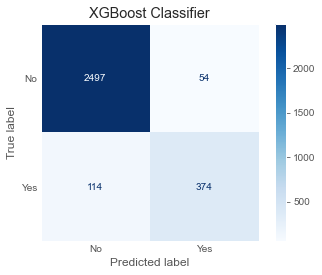

In [354]:
evaluate_model(xgb_best_estimator,X_test,y_test, 'XGBoost Classifier')

### Feature Importance

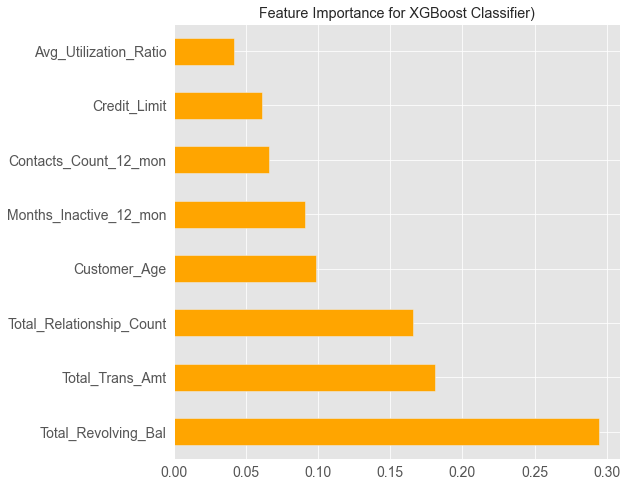

In [334]:
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.title('Feature Importance for XGBoost Classifier)')
feat_importances = pd.Series(xgb_best_estimator.named_steps["clf"].feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh',fontsize=14,color='orange')
plt.show()

### Metrics Comparision

In [326]:
evaluation.sort_values(by ='ROC_AUC', ascending = False)

,Model,Accuracy,Recall,Precision,F1,ROC_AUC
5,XGBoost Classifier,94.471866,76.639344,87.383178,81.659389,96.852930
1,RandomForest Classifier,93.682132,70.491803,87.755102,78.181818,96.066353
2,RandomForest Classifier,93.682132,70.491803,87.755102,78.181818,96.066353
3,KNeigbours Classifier,88.483054,30.737705,92.592593,46.153846,90.755313
4,KNeigbours Classifier,88.483054,30.737705,92.592593,46.153846,90.755313
0,Logistic Regression,76.373807,73.565574,37.869198,50.000000,81.282814


XGBoost Classifier tops interms of ROC_AUC and F1 score.
If I look for Precision KNeigbours Classifie leads.

### ROC Curve 

<ipython-input-331-4a9ec334c3d4>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


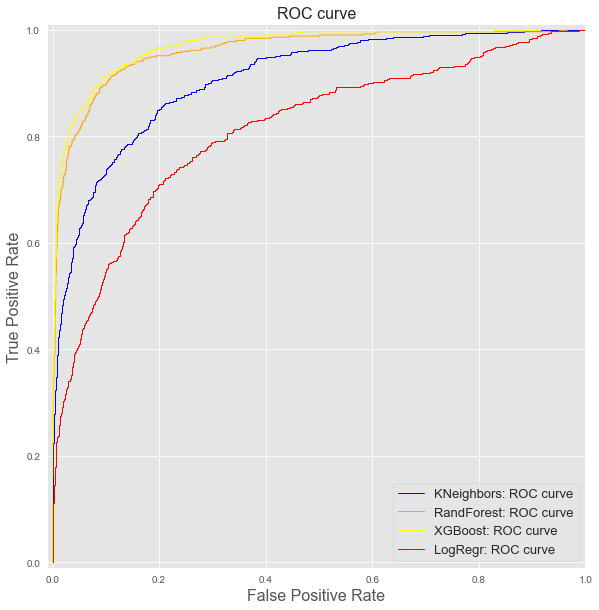

In [331]:
y_proba_knn = knn_best_estimator.predict_proba(X_test.values)
y_proba_rfc = rfc_best_estimator.predict_proba(X_test.values)
y_proba_xgb = xgb_best_estimator.predict_proba(X_test)
y_scores_log = log_best_estimator.decision_function(X_test.values)

fpr_knn, tpr_knn, knn_thresholds = metrics.roc_curve(y_test, y_proba_knn[:,1])
fpr_rfc, tpr_rfc, rfc_thresholds = metrics.roc_curve(y_test, y_proba_rfc[:,1])
fpr_xgb, tpr_xgb, xgb_thresholds = metrics.roc_curve(y_test, y_proba_xgb[:,1])
fpr_log, tpr_log, log_thresholds = metrics.roc_curve(y_test, y_scores_log)

plt.figure(figsize=(10,10))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_knn, tpr_knn, lw=1, label='KNeighbors: ROC curve', color='blue')
plt.plot(fpr_rfc, tpr_rfc, lw=1, label='RandForest: ROC curve', color='orange')
plt.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost: ROC curve', color='yellow')
plt.plot(fpr_log, tpr_log, lw=1, label='LogRegr: ROC curve', color='red')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.axes().set_aspect('equal')
plt.show();

## Additional Models: <a id=AdditionalModels></a>

We have selected four of the many machine learning models available. It would be interesting to see the results of other models. Feature importance: With the knowledge of the feature importance, we can run the model on a dataset containing only the important features and compare the results.

Along with neural networks, other popular prediction techniques can be applied in combination, such as support vector machine develop hybrid model


## Summary <a id =Summary> </a>

XGbooost performed best with grid search along with Random Forest among teh four models interms of ROC_AUC

The top 3 most important feature from  all 4 selected models are:

    Total_Revolving_Bal (Total revolving balance on the credit card)
    Total_Trans_Amt (Total transaction count in the last 12 months)
    Total_Relationship_Count (Total number of products held by the customer)

It can be concluded above 3 features are the most important common predictor of churners based on these findings.


## Recommendations <a id = Recom></a>

Lower transcation count on credit card , less revolving balance , less transcational amount are an indication that customer will attrite.
Lower transcation indicate customer is not using this credit card , Bank may need to consider Cash back, or rewards or some other offers to customer to use the credit card more.

  From the EDA 
* Customers who have had high number of contacts with the bank in the last 12 months have attrited. This needs to be investigated whether there were any issues of customers that were not resolved made customer leaving the bank.
* The proportion of income category of attrited customer, it is highly concentrated around 60K - 80K income, followed by Less than 40K income  compare to attrited customers with higher annual income of 80K-120K and over 120K+.
* Customers who are inactive for a month show high chances of attrition.Bank should focus on these customers as well.
* Customer in age range 36-55 ,who were doctorate or postgraduate  and/or Female attrited more.Reasons need to be further investigated.
* customer having more product with the bank he/she is less likely to attrite.This may be indication for Bank to offer different service to customer.
* Avg utilization ratio is lower amongst attrited customers.